# Stage 4: Member task

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image



from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
cases = pd.read_csv('covid_confirmed_usafacts.csv')
deaths =  pd.read_csv('covid_deaths_usafacts.csv')
beds = pd.read_csv('COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State.csv')
politics = pd.read_csv('pol_final_merge.csv')

## New York State and 5 County Analysis 

Seperating out the New York state data from cases and deaths.

In [3]:
new_york_cases =  cases[cases['State'].map(lambda State: 'NY' in State)]
new_york_deaths =  deaths[deaths['State'].map(lambda State: 'NY' in State)]

Here we will get rid of unnecessary columns and get a dataframe that is easier to read for both cases and deaths.

In [4]:
ny_cases = new_york_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in ny_cases.iloc[:,:39].columns:
    extraneous_columns.append(col)
extraneous_columns
ny_cases = ny_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,533):
  new_cases[column] = ny_cases.iloc[:,column] - ny_cases.iloc[:,column-1]
ny_cases = new_cases.sum().to_frame().reset_index()
ny_cases = ny_cases.rename(columns = {'index': 'days_since', 0: 'new_cases'})
ny_cases['days_since'] = ny_cases['days_since'].apply(lambda x: x-1)

ny_cases

days_since  new_cases
0             0          1
1             1          1
2             2          9
3             3         12
4             4          2
..          ...        ...
527         527       4150
528         528       4701
529         529       4591
530         530          0
531         531       8953

[532 rows x 2 columns]

In [5]:
ny_deaths = new_york_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in ny_deaths.iloc[:,:51].columns:
    extraneous_columns.append(col)
extraneous_columns
ny_deaths = ny_deaths.drop(columns=extraneous_columns)
new_deaths = pd.DataFrame()

for column in range(1,521):
  new_deaths[column] = ny_deaths.iloc[:,column] - ny_deaths.iloc[:,column-1]
ny_deaths = new_deaths.sum().to_frame().reset_index()
ny_deaths = ny_deaths.rename(columns = {'index': 'days_since', 0: 'new_deaths'})
ny_deaths['days_since'] = ny_deaths['days_since'].apply(lambda x: x-1)

ny_deaths

days_since  new_deaths
0             0           3
1             1           0
2             2          11
3             3           8
4             4           8
..          ...         ...
515         515          37
516         516           0
517         517          46
518         518           0
519         519           0

[520 rows x 2 columns]

We will train our models for prediction using the 'days_since' and 'new_cases' columns.

In [6]:
x = ny_cases['days_since']
y = ny_cases['new_cases']
ny_lm = smf.ols(formula= 'new_cases ~ days_since', data = ny_cases).fit()
ny_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=ny_cases).fit()
ny_poly_3 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                       data=ny_cases).fit()
ny_lm.params

Intercept     3257.726403
days_since       3.225936
dtype: float64

Plotting the linear and polynomial prediction lines to see which works best.

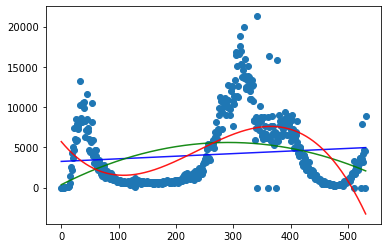

In [7]:
plt.scatter(ny_cases.days_since, ny_cases.new_cases)
x = pd.DataFrame({'days_since': np.linspace(ny_cases.days_since.min(), ny_cases.days_since.max(), 532)})
plt.plot(ny_cases.days_since, ny_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % ny_lm.rsquared, alpha=0.9)
plt.plot(ny_cases.days_since, ny_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % ny_poly_2.rsquared, alpha=0.9)
plt.plot(ny_cases.days_since, ny_poly_3.predict(x), 'r-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % ny_poly_3.rsquared)


In [8]:
ny_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     7.150
Date:                Thu, 28 Apr 2022   Prob (F-statistic):            0.00773
Time:                        15:02:00   Log-Likelihood:                -5201.5
No. Observations:                 532   AIC:                         1.041e+04
Df Residuals:                     530   BIC:                         1.042e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3257.7264    370.045      8.804      0.000    2530.792    3984.661
days_since     3.2259      1.206      2.674      0.008       0.856       5.596
==============================================================================
Omnibus:                       95.091   Durbin-Watson:                   0.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.099
Skew:                           1.203   Prob(JB):                     5.12e-32
Kurtosis:                       3.845   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
ny_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     30.98
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.89e-13
Time:                        15:02:00   Log-Likelihood:                -5175.6
No. Observations:                 532   AIC:                         1.036e+04
Df Residuals:                     529   BIC:                         1.037e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              368.8915    527.952      0.699      0.485    -668.249    1406.032
days_since              35.9297      4.593      7.823      0.000      26.907      44.952
I(days_since ** 2.0)    -0.0616      0.008     -7.355      0.000      -0.078      -0.045
==============================================================================
Omnibus:                       76.927   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.394
Skew:                           1.066   Prob(JB):                     4.78e-24
Kurtosis:                       3.545   Cond. No.                     3.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
ny_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     87.08
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           8.65e-46
Time:                        15:02:00   Log-Likelihood:                -5098.1
No. Observations:                 532   AIC:                         1.020e+04
Df Residuals:                     528   BIC:                         1.022e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5711.3150    607.133      9.407      0.000    4518.622    6904.009
days_since             -85.3739      9.911     -8.614      0.000    -104.844     -65.904
I(days_since ** 2.0)     0.5101      0.043     11.753      0.000       0.425       0.595
I(days_since ** 3.0)    -0.0007   5.37e-05    -13.360      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       87.143   Durbin-Watson:                   0.344
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.037
Skew:                           1.080   Prob(JB):                     3.51e-29
Kurtosis:                       4.115   Cond. No.                     2.25e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From looking at the graph and the R-squared values it appears as though our ny_poly_2 model has the best balance.

Next we create a new dataframe to hold the 7 forecast dates.

In [11]:
X_new = pd.DataFrame({'days_since':[532,533,534,535,536,537,538]})
X_new

days_since
0         532
1         533
2         534
3         535
4         536
5         537
6         538

We call the predict function on the new dataframe using our ny_poly_2 model.

In [12]:
ny_poly_2.predict(X_new)

0    2052.324097
1    2022.661475
2    1992.875674
3    1962.966696
4    1932.934539
5    1902.779205
6    1872.500692
dtype: float64

Grabbing the confidence interval.

In [13]:
ny_poly_2.conf_int()

0            1
Intercept            -668.248586  1406.031657
days_since             26.907297    44.952156
I(days_since ** 2.0)   -0.078039    -0.045139

Graphing the prediction line and adding confidence intervals and forecast.

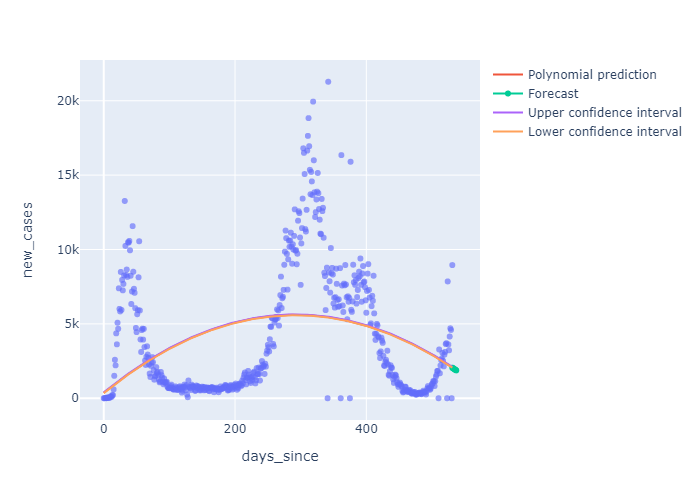

In [14]:
fig = px.scatter(ny_cases, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = ny_cases.days_since, y = ny_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = ny_cases.days_since + 531, y = ny_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = ny_cases.days_since, y = ny_poly_2.predict(x) + 26.907297, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = ny_cases.days_since, y = ny_poly_2.predict(x) - 26.907297, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

We can see that the beginning of our forecast has 2052 new cases on day 531 and this decreases to 1872 by day 537. This model is relying on the spike in the middle of the data to be the max and the other modes to remain much smaller going forward. Given contextual information-i.e. the developement of the vaccine- this may be an astute assumption.

Repeating this process for deaths.

In [15]:
x = ny_deaths['days_since']
y = ny_deaths['new_deaths']
ny_deaths_lm = smf.ols(formula= 'new_deaths ~ days_since', data = ny_deaths).fit()
ny_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=ny_deaths).fit()
ny_deaths_poly_3 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                       data=ny_deaths).fit()
ny_deaths_lm.params

Intercept     227.609021
days_since     -0.479729
dtype: float64

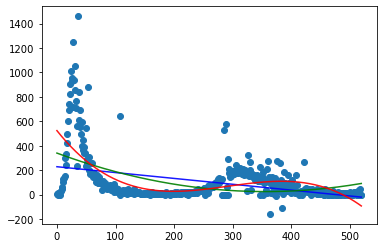

In [16]:
plt.scatter(ny_deaths.days_since, ny_deaths.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(ny_deaths.days_since.min(), ny_deaths.days_since.max(), 520)})
X_new = pd.DataFrame({'days_since':[521,522,523,524,525,526,527]})
plt.plot(ny_deaths.days_since, ny_deaths_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % ny_deaths_lm.rsquared, alpha=0.9)
plt.plot(ny_deaths.days_since, ny_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         ny_deaths_poly_2.rsquared, alpha=0.9)
plt.plot(ny_deaths.days_since, ny_deaths_poly_3.predict(x), 'r-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % 
         ny_deaths_poly_3.rsquared)

In [17]:
ny_deaths_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     88.07
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.98e-19
Time:                        15:02:02   Log-Likelihood:                -3422.5
No. Observations:                 520   AIC:                             6849.
Df Residuals:                     518   BIC:                             6857.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    227.6090     15.325     14.852      0.000     197.502     257.716
days_since    -0.4797      0.051     -9.384      0.000      -0.580      -0.379
==============================================================================
Omnibus:                      341.115   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3502.926
Skew:                           2.806   Prob(JB):                         0.00
Kurtosis:                      14.410   Cond. No.                         599.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
ny_deaths_poly_2.conf_int()

0           1
Intercept             296.059134  382.443200
days_since             -2.157312   -1.388451
I(days_since ** 2.0)    0.001775    0.003209

In [19]:
ny_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     71.21
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           4.84e-28
Time:                        15:02:02   Log-Likelihood:                -3400.1
No. Observations:                 520   AIC:                             6806.
Df Residuals:                     517   BIC:                             6819.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              339.2512     21.986     15.431      0.000     296.059     382.443
days_since              -1.7729      0.196     -9.060      0.000      -2.157      -1.388
I(days_since ** 2.0)     0.0025      0.000      6.826      0.000       0.002       0.003
==============================================================================
Omnibus:                      296.345   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2489.577
Skew:                           2.396   Prob(JB):                         0.00
Kurtosis:                      12.589   Cond. No.                     3.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
ny_deaths_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     94.52
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           9.18e-49
Time:                        15:02:02   Log-Likelihood:                -3349.4
No. Observations:                 520   AIC:                             6707.
Df Residuals:                     516   BIC:                             6724.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              523.2471     26.532     19.721      0.000     471.123     575.371
days_since              -6.0477      0.443    -13.647      0.000      -6.918      -5.177
I(days_since ** 2.0)     0.0231      0.002     11.637      0.000       0.019       0.027
I(days_since ** 3.0) -2.648e-05   2.51e-06    -10.530      0.000   -3.14e-05   -2.15e-05
==============================================================================
Omnibus:                      261.921   Durbin-Watson:                   0.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3481.421
Skew:                           1.862   Prob(JB):                         0.00
Kurtosis:                      15.117   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

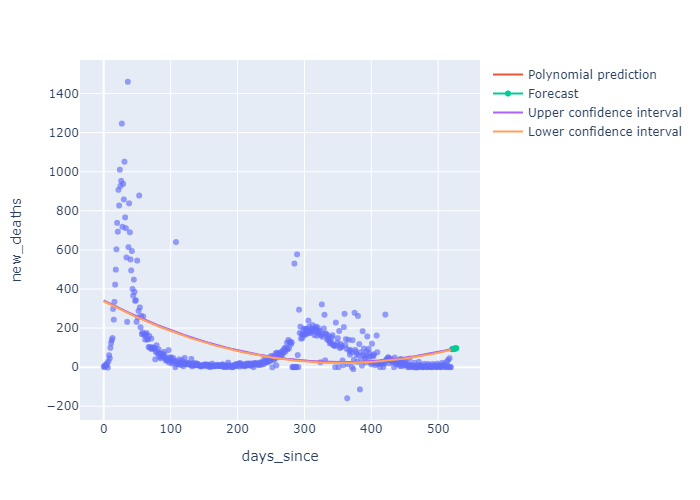

In [21]:
fig = px.scatter(ny_deaths, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = ny_deaths.days_since, y = ny_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = ny_deaths.days_since + 521, y = ny_deaths_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = ny_deaths.days_since, y = ny_deaths_poly_2.predict(x) + 2.157312, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = ny_deaths.days_since, y = ny_deaths_poly_2.predict(x) - 2.157312, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph for deaths shows a forecast of 92 deaths on day 521 and 97 deaths 7 days past that. The prediction seems to indicate an uptick in deaths which may just be a result of the data ending at a valley with upward movement toward the end.

### King county Analysis

In [22]:
king_cases =  cases.drop(cases.index[cases['countyFIPS']!= 36047])
king_cases = king_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in king_cases.iloc[:,:42].columns:
    extraneous_columns.append(col)
extraneous_columns
king_cases = king_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,531):
  new_cases[column] = king_cases.iloc[:,column] - king_cases.iloc[:,column-1]
king_cases = new_cases.sum().to_frame().reset_index()
king_cases = king_cases.rename(columns = {'index': 'days_since', 0: 'new_cases'})
king_cases['days_since'] = king_cases['days_since'].apply(lambda x: x-1)

king_deaths =  deaths.drop(deaths.index[deaths['countyFIPS']!= 36047])
king_deaths = king_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in king_deaths.iloc[:,:51].columns:
    extraneous_columns.append(col)
extraneous_columns
king_deaths = king_deaths.drop(columns=extraneous_columns)
new_deaths = pd.DataFrame()
for column in range(1,522):
  new_deaths[column] = king_deaths.iloc[:,column] - king_deaths.iloc[:,column-1]
king_deaths = new_deaths.sum().to_frame().reset_index()
king_deaths = king_deaths.rename(columns = {'index': 'days_since', 0: 'new_deaths'})
king_deaths['days_since'] = king_deaths['days_since'].apply(lambda x: x-1)

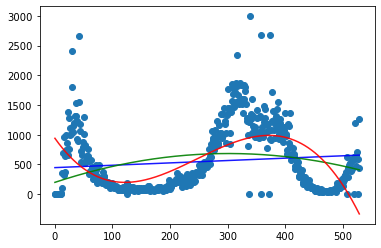

In [23]:
x = king_cases['days_since']
y = king_cases['new_cases']
k_lm = smf.ols(formula= 'new_cases ~ days_since', data = king_cases).fit()
k_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=king_cases).fit()
k_poly_3 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=king_cases).fit()
plt.scatter(king_cases.days_since, king_cases.new_cases)
x = pd.DataFrame({'days_since': np.linspace(king_cases.days_since.min(), king_cases.days_since.max(), 530)})
X_new = pd.DataFrame({'days_since':[531,532,533,534,535,536,537]})
plt.plot(king_cases.days_since, k_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % k_lm.rsquared, alpha=0.9)
plt.plot(king_cases.days_since, k_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % k_poly_2.rsquared, alpha=0.9)
plt.plot(king_cases.days_since, k_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % k_poly_3.rsquared, alpha=0.9)

In [24]:
k_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.546
Date:                Thu, 28 Apr 2022   Prob (F-statistic):             0.0108
Time:                        15:02:10   Log-Likelihood:                -4093.1
No. Observations:                 530   AIC:                             8190.
Df Residuals:                     528   BIC:                             8199.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    446.1133     47.514      9.389      0.000     352.773     539.454
days_since     0.3978      0.155      2.558      0.011       0.092       0.703
==============================================================================
Omnibus:                      100.525   Durbin-Watson:                   0.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.197
Skew:                           1.199   Prob(JB):                     1.64e-35
Kurtosis:                       4.225   Cond. No.                         610.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
k_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     14.84
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           5.35e-07
Time:                        15:02:10   Log-Likelihood:                -4081.8
No. Observations:                 530   AIC:                             8170.
Df Residuals:                     527   BIC:                             8182.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              198.2130     69.675      2.845      0.005      61.338     335.088
days_since               3.2149      0.608      5.284      0.000       2.020       4.410
I(days_since ** 2.0)    -0.0053      0.001     -4.783      0.000      -0.008      -0.003
==============================================================================
Omnibus:                      103.657   Durbin-Watson:                   0.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.759
Skew:                           1.203   Prob(JB):                     8.32e-38
Kurtosis:                       4.393   Cond. No.                     3.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
k_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     82.13
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.36e-43
Time:                        15:02:10   Log-Likelihood:                -3994.5
No. Observations:                 530   AIC:                             7997.
Df Residuals:                     526   BIC:                             8014.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              939.8734     78.610     11.956      0.000     785.446    1094.301
days_since             -13.6890      1.288    -10.627      0.000     -16.220     -11.159
I(days_since ** 2.0)     0.0746      0.006     13.183      0.000       0.064       0.086
I(days_since ** 3.0)    -0.0001   7.03e-06    -14.325      0.000      -0.000    -8.7e-05
==============================================================================
Omnibus:                      104.726   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.522
Skew:                           1.050   Prob(JB):                     1.45e-50
Kurtosis:                       5.446   Cond. No.                     2.23e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
k_poly_2.conf_int()

0           1
Intercept             61.337516  335.088498
days_since             2.019659    4.410115
I(days_since ** 2.0)  -0.007513   -0.003138

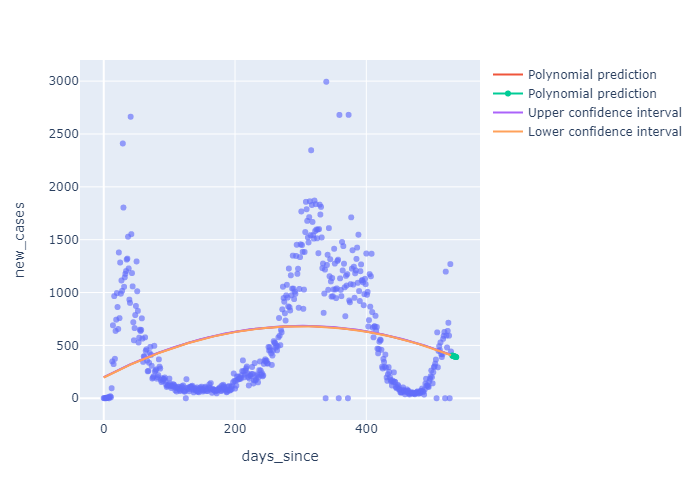

In [28]:
fig = px.scatter(king_cases, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = king_cases.days_since, y = k_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = king_cases.days_since + 531, y = k_poly_2.predict(X_new), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = king_cases.days_since, y = k_poly_2.predict(x) + 2.019659, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = king_cases.days_since, y = k_poly_2.predict(x) - 2.019659, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows a forecast of 404 new cases on day 531 and this decreases to 389 by day 537. This would indicate the prediction model sees an overall downward trend moving forward.

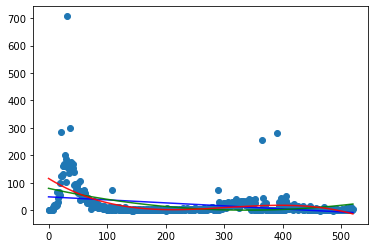

In [29]:
x = king_deaths['days_since']
y = king_deaths['new_deaths']
k_deaths_lm = smf.ols(formula= 'new_deaths ~ days_since', data = king_deaths).fit()
k_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=king_deaths).fit()
k_deaths_poly_3 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=king_deaths).fit()
plt.scatter(king_deaths.days_since, king_deaths.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(king_deaths.days_since.min(), king_deaths.days_since.max(), 521)})
X_new = pd.DataFrame({'days_since':[522,523,524,525,526,527,528]})
plt.plot(king_deaths.days_since, k_deaths_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % k_deaths_lm.rsquared, alpha=0.9)
plt.plot(king_deaths.days_since, k_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         k_deaths_poly_2.rsquared, alpha=0.9)
plt.plot(king_deaths.days_since, k_deaths_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % 
         k_deaths_poly_3.rsquared, alpha=0.9)

In [30]:
k_deaths_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     62.70
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.47e-14
Time:                        15:02:10   Log-Likelihood:                -2751.3
No. Observations:                 521   AIC:                             5507.
Df Residuals:                     519   BIC:                             5515.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.8154      4.168     11.711      0.000      40.626      57.005
days_since    -0.1099      0.014     -7.918      0.000      -0.137      -0.083
==============================================================================
Omnibus:                      706.913   Durbin-Watson:                   0.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132042.695
Skew:                           6.835   Prob(JB):                         0.00
Kurtosis:                      79.784   Cond. No.                         600.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
k_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     58.49
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.25e-23
Time:                        15:02:10   Log-Likelihood:                -2727.9
No. Observations:                 521   AIC:                             5462.
Df Residuals:                     518   BIC:                             5475.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               79.7578      5.970     13.359      0.000      68.029      91.487
days_since              -0.4676      0.053     -8.817      0.000      -0.572      -0.363
I(days_since ** 2.0)     0.0007   9.87e-05      6.967      0.000       0.000       0.001
==============================================================================
Omnibus:                      711.645   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146327.020
Skew:                           6.876   Prob(JB):                         0.00
Kurtosis:                      83.941   Cond. No.                     3.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
k_deaths_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     60.28
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.97e-33
Time:                        15:02:10   Log-Likelihood:                -2702.8
No. Observations:                 521   AIC:                             5414.
Df Residuals:                     517   BIC:                             5431.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              115.7964      7.568     15.301      0.000     100.929     130.664
days_since              -1.3033      0.126    -10.330      0.000      -1.551      -1.055
I(days_since ** 2.0)     0.0047      0.001      8.349      0.000       0.004       0.006
I(days_since ** 3.0) -5.156e-06   7.13e-07     -7.231      0.000   -6.56e-06   -3.75e-06
==============================================================================
Omnibus:                      719.330   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           177774.026
Skew:                           6.931   Prob(JB):                         0.00
Kurtosis:                      92.426   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
k_deaths_poly_2.conf_int()

0          1
Intercept             68.028808  91.486760
days_since            -0.571799  -0.363413
I(days_since ** 2.0)   0.000494   0.000882

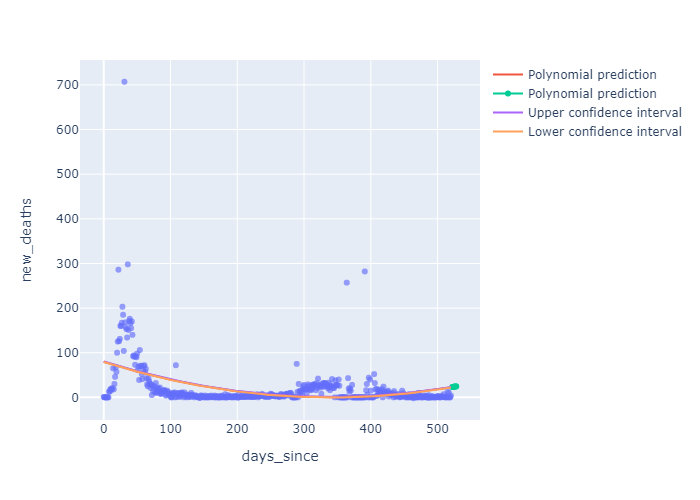

In [34]:
fig = px.scatter(king_deaths, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = king_deaths.days_since, y = k_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = king_deaths.days_since + 522, y = k_deaths_poly_2.predict(X_new), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = king_deaths.days_since, y = k_deaths_poly_2.predict(x) + 0.571799, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = king_deaths.days_since, y = k_deaths_poly_2.predict(x) - 0.571799, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The deaths graph shows 23 predicted deaths on day 522 and predicts 25 by day 528. The model seems to believe deaths will slowly increase in the coming week.

### Queens county Analysis

In [35]:
queens_cases =  cases.drop(cases.index[cases['countyFIPS']!= 36081])
queens_cases = queens_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in queens_cases.iloc[:,:44].columns:
    extraneous_columns.append(col)
extraneous_columns
queens_cases = queens_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,529):
  new_cases[column] = queens_cases.iloc[:,column] - queens_cases.iloc[:,column-1]
queens_cases = new_cases.sum().to_frame().reset_index()
queens_cases = queens_cases.rename(columns = {'index': 'days_since', 0: 'new_cases'})
queens_cases['days_since'] = queens_cases['days_since'].apply(lambda x: x-1)

queens_deaths =  deaths.drop(deaths.index[cases['countyFIPS']!= 36081])
queens_deaths = queens_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in queens_deaths.iloc[:,:59].columns:
    extraneous_columns.append(col)
extraneous_columns
queens_deaths = queens_deaths.drop(columns=extraneous_columns)
new_deaths = pd.DataFrame()
for column in range(1,514):
  new_deaths[column] = queens_deaths.iloc[:,column] - queens_deaths.iloc[:,column-1]
queens_deaths = new_deaths.sum().to_frame().reset_index()
queens_deaths = queens_deaths.rename(columns = {'index': 'days_since', 0: 'new_deaths'})
queens_deaths['days_since'] = queens_deaths['days_since'].apply(lambda x: x-1)

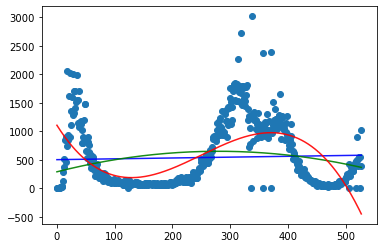

In [36]:
x = queens_cases['days_since']
y = queens_cases['new_cases']
q_lm = smf.ols(formula= 'new_cases ~ days_since', data = queens_cases).fit()
q_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=queens_cases).fit()
q_poly_3 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=queens_cases).fit()
plt.scatter(queens_cases.days_since, queens_cases.new_cases)
x = pd.DataFrame({'days_since': np.linspace(queens_cases.days_since.min(), queens_cases.days_since.max(), 528)})
X_new = pd.DataFrame({'days_since':[529,530,531,532,533,534,535]})
plt.plot(queens_cases.days_since, q_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % q_lm.rsquared, alpha=0.9)
plt.plot(queens_cases.days_since, q_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % q_poly_2.rsquared, alpha=0.9)
plt.plot(queens_cases.days_since, q_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % q_poly_3.rsquared, alpha=0.9)

In [37]:
q_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8281
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.363
Time:                        15:02:18   Log-Likelihood:                -4095.4
No. Observations:                 528   AIC:                             8195.
Df Residuals:                     526   BIC:                             8203.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    500.5428     49.234     10.167      0.000     403.823     597.262
days_since     0.1472      0.162      0.910      0.363      -0.171       0.465
==============================================================================
Omnibus:                       87.721   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.782
Skew:                           1.158   Prob(JB):                     1.08e-28
Kurtosis:                       3.702   Cond. No.                         608.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
q_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     8.183
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           0.000317
Time:                        15:02:18   Log-Likelihood:                -4087.7
No. Observations:                 528   AIC:                             8181.
Df Residuals:                     525   BIC:                             8194.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              287.5627     72.681      3.957      0.000     144.782     430.344
days_since               2.5766      0.637      4.044      0.000       1.325       3.828
I(days_since ** 2.0)    -0.0046      0.001     -3.939      0.000      -0.007      -0.002
==============================================================================
Omnibus:                       87.936   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.329
Skew:                           1.149   Prob(JB):                     8.25e-29
Kurtosis:                       3.771   Cond. No.                     3.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
q_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     87.82
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           4.77e-46
Time:                        15:02:18   Log-Likelihood:                -3988.3
No. Observations:                 528   AIC:                             7985.
Df Residuals:                     524   BIC:                             8002.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1104.1106     80.086     13.787      0.000     946.782    1261.439
days_since             -16.1051      1.317    -12.226      0.000     -18.693     -13.517
I(days_since ** 2.0)     0.0841      0.006     14.470      0.000       0.073       0.096
I(days_since ** 3.0)    -0.0001   7.25e-06    -15.481      0.000      -0.000    -9.8e-05
==============================================================================
Omnibus:                       71.399   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.027
Skew:                           0.859   Prob(JB):                     1.05e-25
Kurtosis:                       4.508   Cond. No.                     2.20e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
q_poly_2.conf_int()

0           1
Intercept             144.781642  430.343811
days_since              1.325085    3.828143
I(days_since ** 2.0)   -0.006909   -0.002311

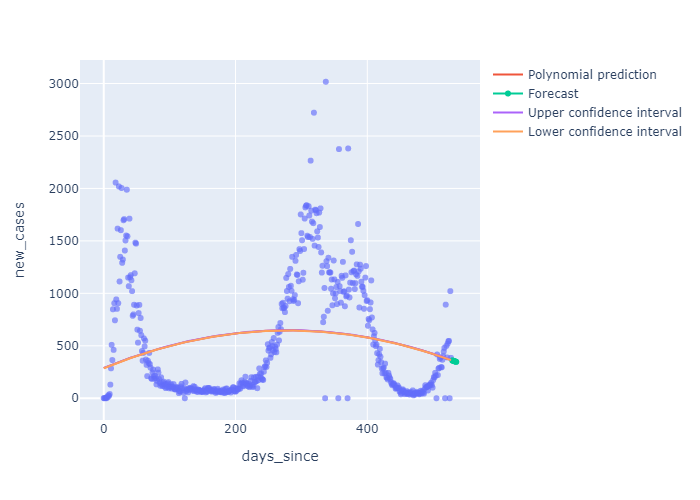

In [41]:
fig = px.scatter(queens_cases, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = queens_cases.days_since, y = q_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = queens_cases.days_since + 529, y = q_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = queens_cases.days_since, y = q_poly_2.predict(x) + 1.325085, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = queens_cases.days_since, y = q_poly_2.predict(x) - 1.325085, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows a prediction of 361 new cases on day 529 which drops down to 347 by day 535. The prediction model seems to indicate the trend of new cases is headed downward after a recent spike.

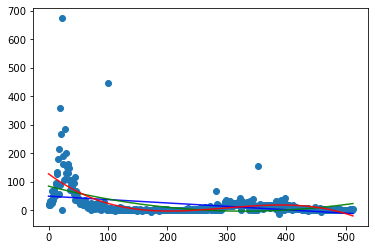

In [42]:
x = queens_deaths['days_since']
y = queens_deaths['new_deaths']
q_deaths_lm = smf.ols(formula= 'new_deaths ~ days_since', data = queens_deaths).fit()
q_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=queens_deaths).fit()
q_deaths_poly_3 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=queens_deaths).fit()
plt.scatter(queens_deaths.days_since, queens_deaths.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(queens_deaths.days_since.min(), queens_deaths.days_since.max(), 513)})
X_new = pd.DataFrame({'days_since': [514,515,516,517,518,519,520]})
plt.plot(queens_deaths.days_since, q_deaths_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % q_deaths_lm.rsquared, alpha=0.9)
plt.plot(queens_deaths.days_since, q_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         q_deaths_poly_2.rsquared, alpha=0.9)
plt.plot(queens_deaths.days_since, q_deaths_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % 
         q_deaths_poly_3.rsquared, alpha=0.9)

In [43]:
q_deaths_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     69.11
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           8.48e-16
Time:                        15:02:18   Log-Likelihood:                -2713.1
No. Observations:                 513   AIC:                             5430.
Df Residuals:                     511   BIC:                             5439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.0066      4.235     11.809      0.000      41.687      58.326
days_since    -0.1190      0.014     -8.313      0.000      -0.147      -0.091
==============================================================================
Omnibus:                      698.282   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           112635.401
Skew:                           6.938   Prob(JB):                         0.00
Kurtosis:                      74.253   Cond. No.                         591.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
q_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     69.69
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.75e-27
Time:                        15:02:18   Log-Likelihood:                -2683.7
No. Observations:                 513   AIC:                             5373.
Df Residuals:                     510   BIC:                             5386.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               85.0942      5.989     14.208      0.000      73.328      96.861
days_since              -0.5310      0.054     -9.827      0.000      -0.637      -0.425
I(days_since ** 2.0)     0.0008      0.000      7.876      0.000       0.001       0.001
==============================================================================
Omnibus:                      708.037   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           127747.745
Skew:                           7.071   Prob(JB):                         0.00
Kurtosis:                      79.003   Cond. No.                     3.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
q_deaths_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     79.86
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.38e-42
Time:                        15:02:18   Log-Likelihood:                -2646.7
No. Observations:                 513   AIC:                             5301.
Df Residuals:                     509   BIC:                             5318.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              128.4528      7.412     17.330      0.000     113.890     143.015
days_since              -1.5522      0.125    -12.368      0.000      -1.799      -1.306
I(days_since ** 2.0)     0.0058      0.001     10.170      0.000       0.005       0.007
I(days_since ** 3.0) -6.499e-06   7.32e-07     -8.883      0.000   -7.94e-06   -5.06e-06
==============================================================================
Omnibus:                      750.552   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183973.095
Skew:                           7.780   Prob(JB):                         0.00
Kurtosis:                      94.460   Cond. No.                     2.02e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
q_deaths_poly_2.conf_int()

0          1
Intercept             73.327871  96.860514
days_since            -0.637179  -0.424863
I(days_since ** 2.0)   0.000604   0.001005

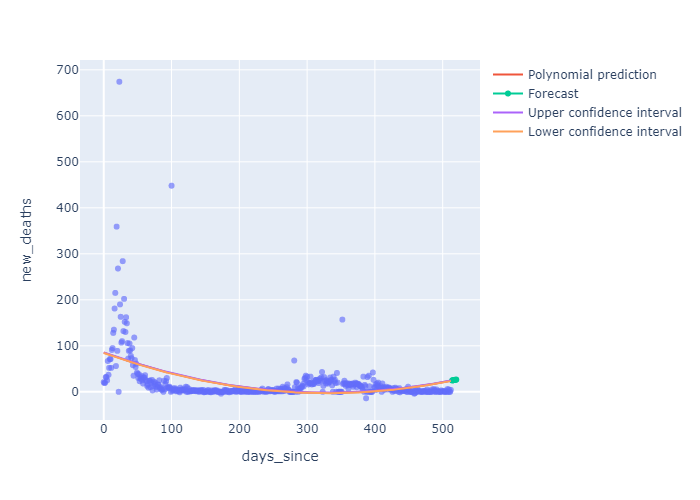

In [47]:
fig = px.scatter(queens_deaths, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = queens_deaths.days_since, y = q_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = queens_deaths.days_since + 514, y = q_deaths_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = queens_deaths.days_since, y = q_deaths_poly_2.predict(x) + 0.637179, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = queens_deaths.days_since, y = q_deaths_poly_2.predict(x) - 0.637179, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows a prediction of 25 deaths on day 514 which increases to 27 by day 520. The prediction is suggesting that more deaths will occur at a higher rate in the next week.

### Suffolk county Analysis

In [48]:
suffolk_cases = cases.drop(cases.index[cases['countyFIPS']!= 36103])
suffolk_cases = suffolk_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in suffolk_cases.iloc[:,:45].columns:
    extraneous_columns.append(col)
extraneous_columns
suffolk_cases = suffolk_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,528):
  new_cases[column] = suffolk_cases.iloc[:,column] - suffolk_cases.iloc[:,column-1]
suffolk_cases = new_cases.sum().to_frame().reset_index()
suffolk_cases = suffolk_cases.rename(columns = {'index': 'days_since', 0: 'new_cases'})
suffolk_cases['days_since'] = suffolk_cases['days_since'].apply(lambda x: x-1)

suffolk_deaths = deaths.drop(deaths.index[cases['countyFIPS']!= 36103])
suffolk_deaths = suffolk_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in suffolk_deaths.iloc[:,:53].columns:
    extraneous_columns.append(col)
extraneous_columns
suffolk_deaths = suffolk_deaths.drop(columns=extraneous_columns)
new_deaths = pd.DataFrame()
for column in range(1,520):
  new_deaths[column] = suffolk_deaths.iloc[:,column] - suffolk_deaths.iloc[:,column-1]
suffolk_deaths = new_deaths.sum().to_frame().reset_index()
suffolk_deaths = suffolk_deaths.rename(columns = {'index': 'days_since', 0: 'new_deaths'})
suffolk_deaths['days_since'] = suffolk_deaths['days_since'].apply(lambda x: x-1)

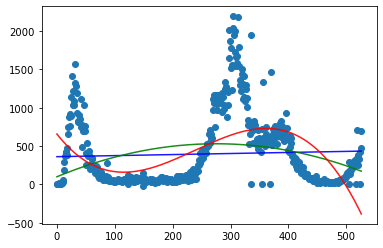

In [49]:
x = suffolk_cases['days_since']
y = suffolk_cases['new_cases']
s_lm = smf.ols(formula= 'new_cases ~ days_since', data = suffolk_cases).fit()
s_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=suffolk_cases).fit()
s_poly_3 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=suffolk_cases).fit()
plt.scatter(suffolk_cases.days_since, suffolk_cases.new_cases)
x = pd.DataFrame({'days_since': np.linspace(suffolk_cases.days_since.min(), suffolk_cases.days_since.max(), 527)})
X_new - pd.DataFrame({'days_since':[528,529,530,531,532,533,534]})
plt.plot(suffolk_cases.days_since, s_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % s_lm.rsquared, alpha=0.9)
plt.plot(suffolk_cases.days_since, s_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % s_poly_2.rsquared, alpha=0.9)
plt.plot(suffolk_cases.days_since, s_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % s_poly_3.rsquared, alpha=0.9)

In [50]:
s_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.069
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.302
Time:                        15:02:25   Log-Likelihood:                -3985.4
No. Observations:                 527   AIC:                             7975.
Df Residuals:                     525   BIC:                             7983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    361.4172     40.593      8.903      0.000     281.673     441.161
days_since     0.1381      0.134      1.034      0.302      -0.124       0.401
==============================================================================
Omnibus:                      133.296   Durbin-Watson:                   0.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.488
Skew:                           1.469   Prob(JB):                     1.81e-54
Kurtosis:                       4.623   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
s_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     18.45
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.80e-08
Time:                        15:02:25   Log-Likelihood:                -3968.0
No. Observations:                 527   AIC:                             7942.
Df Residuals:                     524   BIC:                             7955.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               99.6719     58.828      1.694      0.091     -15.896     215.240
days_since               3.1295      0.517      6.058      0.000       2.115       4.144
I(days_since ** 2.0)    -0.0057      0.001     -5.981      0.000      -0.008      -0.004
==============================================================================
Omnibus:                      113.680   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.535
Skew:                           1.330   Prob(JB):                     4.23e-42
Kurtosis:                       4.264   Cond. No.                     3.70e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
s_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     66.11
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.96e-36
Time:                        15:02:26   Log-Likelihood:                -3901.3
No. Observations:                 527   AIC:                             7811.
Df Residuals:                     523   BIC:                             7828.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              657.3396     68.940      9.535      0.000     521.906     792.773
days_since              -9.6537      1.136     -8.497      0.000     -11.886      -7.422
I(days_since ** 2.0)     0.0551      0.005     10.977      0.000       0.045       0.065
I(days_since ** 3.0) -7.708e-05   6.28e-06    -12.282      0.000   -8.94e-05   -6.47e-05
==============================================================================
Omnibus:                      117.011   Durbin-Watson:                   0.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.750
Skew:                           1.309   Prob(JB):                     1.27e-45
Kurtosis:                       4.599   Cond. No.                     2.19e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
s_poly_2.conf_int()

0           1
Intercept            -15.896430  215.240284
days_since             2.114580    4.144431
I(days_since ** 2.0)  -0.007555   -0.003819

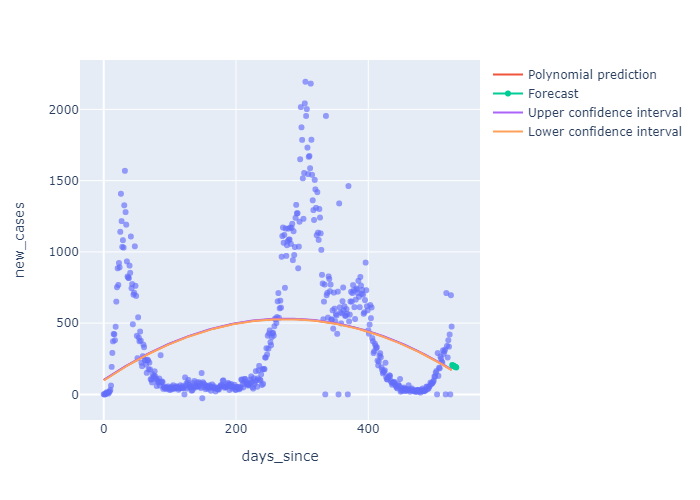

In [54]:
fig = px.scatter(suffolk_cases, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = suffolk_cases.days_since, y = s_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = suffolk_cases.days_since + 527, y = s_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = suffolk_cases.days_since, y = s_poly_2.predict(x) + 2.11458, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = suffolk_cases.days_since, y = s_poly_2.predict(x) - 2.11458, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph predicts there will be 206 new cases on day 527 which with a decrease to 189 new cases on day 533.

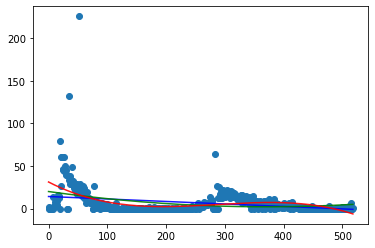

In [55]:
x = suffolk_deaths['days_since']
y = suffolk_deaths['new_deaths']
s_deaths_lm = smf.ols(formula= 'new_deaths ~ days_since', data = suffolk_deaths).fit()
s_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=suffolk_deaths).fit()
s_deaths_poly_3 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=suffolk_deaths).fit()
plt.scatter(suffolk_deaths.days_since, suffolk_deaths.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(suffolk_deaths.days_since.min(), suffolk_deaths.days_since.max(), 519)})
X_new = pd.DataFrame({'days_since':[520,521,522,523,524,525,526]})
plt.plot(suffolk_deaths.days_since, s_deaths_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % s_deaths_lm.rsquared, alpha=0.9)
plt.plot(suffolk_deaths.days_since, s_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         s_deaths_poly_2.rsquared, alpha=0.9)
plt.plot(suffolk_deaths.days_since, s_deaths_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % 
         s_deaths_poly_3.rsquared, alpha=0.9)

In [56]:
s_deaths_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     45.97
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           3.29e-11
Time:                        15:02:26   Log-Likelihood:                -2129.2
No. Observations:                 519   AIC:                             4262.
Df Residuals:                     517   BIC:                             4271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.1460      1.286     11.003      0.000      11.620      16.672
days_since    -0.0291      0.004     -6.780      0.000      -0.038      -0.021
==============================================================================
Omnibus:                      754.092   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           199087.521
Skew:                           7.645   Prob(JB):                         0.00
Kurtosis:                      97.724   Cond. No.                         598.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
s_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     32.30
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           6.08e-14
Time:                        15:02:26   Log-Likelihood:                -2120.7
No. Observations:                 519   AIC:                             4247.
Df Residuals:                     516   BIC:                             4260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               19.9895      1.894     10.552      0.000      16.268      23.711
days_since              -0.0969      0.017     -5.739      0.000      -0.130      -0.064
I(days_since ** 2.0)     0.0001   3.16e-05      4.146      0.000    6.89e-05       0.000
==============================================================================
Omnibus:                      750.850   Durbin-Watson:                   1.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201037.121
Skew:                           7.571   Prob(JB):                         0.00
Kurtosis:                      98.222   Cond. No.                     3.59e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
s_deaths_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     40.31
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.06e-23
Time:                        15:02:26   Log-Likelihood:                -2096.6
No. Observations:                 519   AIC:                             4201.
Df Residuals:                     515   BIC:                             4218.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               31.2103      2.405     12.975      0.000      26.485      35.936
days_since              -0.3581      0.040     -8.897      0.000      -0.437      -0.279
I(days_since ** 2.0)     0.0014      0.000      7.709      0.000       0.001       0.002
I(days_since ** 3.0) -1.624e-06   2.29e-07     -7.084      0.000   -2.07e-06   -1.17e-06
==============================================================================
Omnibus:                      784.733   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           275719.069
Skew:                           8.143   Prob(JB):                         0.00
Kurtosis:                     114.735   Cond. No.                     2.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
s_deaths_poly_2.conf_int()

0          1
Intercept             16.267846  23.711105
days_since            -0.130135  -0.063758
I(days_since ** 2.0)   0.000069   0.000193

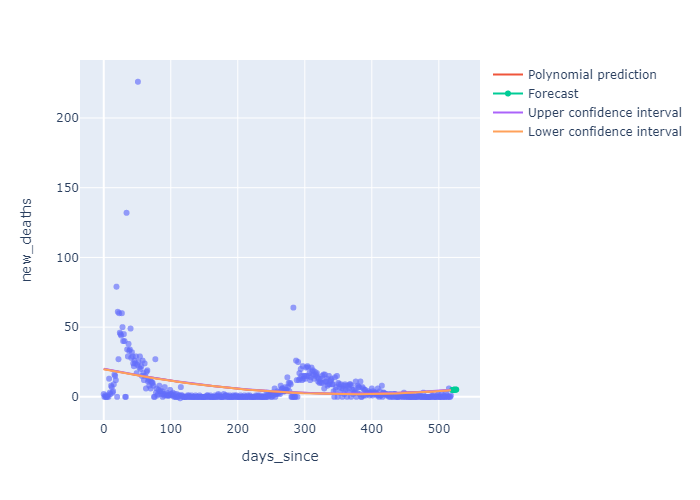

In [60]:
fig = px.scatter(suffolk_deaths, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = suffolk_deaths.days_since, y = s_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = suffolk_deaths.days_since + 520, y = s_deaths_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = suffolk_deaths.days_since, y = s_deaths_poly_2.predict(x) + 0.130135, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = suffolk_deaths.days_since, y = s_deaths_poly_2.predict(x) - 0.130135, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph predicts 5 new deaths on day 520 which will stay relatively steady with a fractional increase on day 526.

### Nassau county Analysis

In [61]:
nassau_cases =  cases.drop(cases.index[cases['countyFIPS']!= 36059])
nassau_cases = nassau_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in nassau_cases.iloc[:,:42].columns:
    extraneous_columns.append(col)
extraneous_columns
nassau_cases = nassau_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,531):
  new_cases[column] = nassau_cases.iloc[:,column] - nassau_cases.iloc[:,column-1]
nassau_cases = new_cases.sum().to_frame().reset_index()
nassau_cases = nassau_cases.rename(columns = {'index': 'days_since', 0: 'new_cases'})
nassau_cases['days_since'] = nassau_cases['days_since'].apply(lambda x: x-1)

nassau_deaths = deaths.drop(deaths.index[cases['countyFIPS']!= 36059])
nassau_deaths = nassau_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in nassau_deaths.iloc[:,:53].columns:
    extraneous_columns.append(col)
extraneous_columns
nassau_deaths = nassau_deaths.drop(columns=extraneous_columns)
new_deaths = pd.DataFrame()
for column in range(1,520):
  new_deaths[column] = nassau_deaths.iloc[:,column] - nassau_deaths.iloc[:,column-1]
nassau_deaths = new_deaths.sum().to_frame().reset_index()
nassau_deaths = nassau_deaths.rename(columns = {'index': 'days_since', 0: 'new_deaths'})
nassau_deaths['days_since'] = nassau_deaths['days_since'].apply(lambda x: x-1)

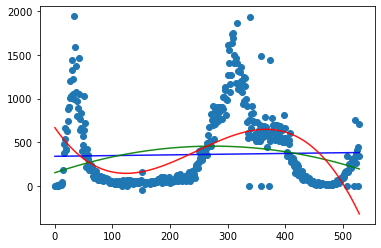

In [62]:
x = nassau_cases['days_since']
y = nassau_cases['new_cases']
n_lm = smf.ols(formula= 'new_cases ~ days_since', data = nassau_cases).fit()
n_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=nassau_cases).fit()
n_poly_3 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=nassau_cases).fit()
plt.scatter(nassau_cases.days_since, nassau_cases.new_cases)
x = pd.DataFrame({'days_since': np.linspace(nassau_cases.days_since.min(), nassau_cases.days_since.max(), 530)})
X_new = pd.DataFrame({'days_since':[531,532,533,534,535.536,537]})
plt.plot(nassau_cases.days_since, n_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % n_lm.rsquared, alpha=0.9)
plt.plot(nassau_cases.days_since, n_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % n_poly_2.rsquared, alpha=0.9)
plt.plot(nassau_cases.days_since, n_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % n_poly_3.rsquared, alpha=0.9)

In [63]:
n_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4673
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.495
Time:                        15:02:33   Log-Likelihood:                -3950.8
No. Observations:                 530   AIC:                             7906.
Df Residuals:                     528   BIC:                             7914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    341.9023     36.327      9.412      0.000     270.540     413.265
days_since     0.0813      0.119      0.684      0.495      -0.152       0.315
==============================================================================
Omnibus:                      123.313   Durbin-Watson:                   0.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.061
Skew:                           1.406   Prob(JB):                     2.00e-47
Kurtosis:                       4.354   Cond. No.                         610.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
n_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     11.36
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.47e-05
Time:                        15:02:33   Log-Likelihood:                -3939.8
No. Observations:                 530   AIC:                             7886.
Df Residuals:                     527   BIC:                             7898.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              154.8965     53.300      2.906      0.004      50.190     259.604
days_since               2.2063      0.465      4.740      0.000       1.292       3.121
I(days_since ** 2.0)    -0.0040      0.001     -4.716      0.000      -0.006      -0.002
==============================================================================
Omnibus:                      124.105   Durbin-Watson:                   0.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.650
Skew:                           1.394   Prob(JB):                     2.01e-48
Kurtosis:                       4.473   Cond. No.                     3.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
n_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     61.94
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.63e-34
Time:                        15:02:33   Log-Likelihood:                -3870.8
No. Observations:                 530   AIC:                             7750.
Df Residuals:                     526   BIC:                             7767.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              667.6064     62.248     10.725      0.000     545.321     789.892
days_since              -9.4793      1.020     -9.293      0.000     -11.483      -7.476
I(days_since ** 2.0)     0.0513      0.004     11.434      0.000       0.042       0.060
I(days_since ** 3.0) -6.966e-05   5.57e-06    -12.506      0.000   -8.06e-05   -5.87e-05
==============================================================================
Omnibus:                      118.518   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.802
Skew:                           1.286   Prob(JB):                     5.07e-48
Kurtosis:                       4.803   Cond. No.                     2.23e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
n_poly_2.conf_int()

0           1
Intercept             50.189596  259.603500
days_since             1.292010    3.120660
I(days_since ** 2.0)  -0.005690   -0.002344

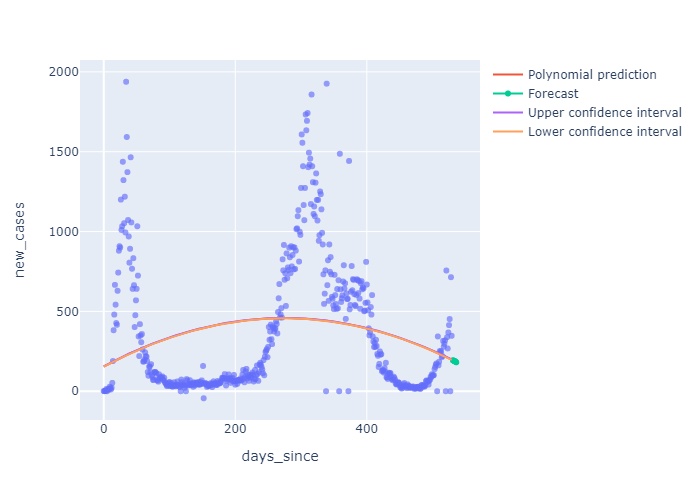

In [67]:
fig = px.scatter(nassau_cases, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = nassau_cases.days_since, y = n_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = nassau_cases.days_since + 531, y = n_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = nassau_cases.days_since, y = n_poly_2.predict(x) + 1.29201, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = nassau_cases.days_since, y = n_poly_2.predict(x) - 1.29201, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows a prediction of 194 new cases on day 531 which will decrease to 181 by day 536.

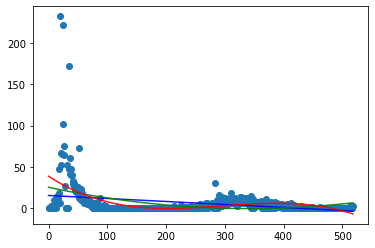

In [68]:
x = nassau_deaths['days_since']
y = nassau_deaths['new_deaths']
n_deaths_lm = smf.ols(formula= 'new_deaths ~ days_since', data = nassau_deaths).fit()
n_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=nassau_deaths).fit()
n_deaths_poly_3 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=nassau_deaths).fit()
plt.scatter(nassau_deaths.days_since, nassau_deaths.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(nassau_deaths.days_since.min(), nassau_deaths.days_since.max(), 519)})
X_new = pd.DataFrame({'days_since':[520,521,522,523,524,525,526]})
plt.plot(nassau_deaths.days_since, n_deaths_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % n_deaths_lm.rsquared, alpha=0.9)
plt.plot(nassau_deaths.days_since, n_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         n_deaths_poly_2.rsquared, alpha=0.9)
plt.plot(nassau_deaths.days_since, n_deaths_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % 
         n_deaths_poly_3.rsquared, alpha=0.9)

In [69]:
n_deaths_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     45.46
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           4.17e-11
Time:                        15:02:34   Log-Likelihood:                -2244.9
No. Observations:                 519   AIC:                             4494.
Df Residuals:                     517   BIC:                             4502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5359      1.607      9.669      0.000      12.379      18.692
days_since    -0.0362      0.005     -6.743      0.000      -0.047      -0.026
==============================================================================
Omnibus:                      753.382   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           143020.753
Skew:                           7.811   Prob(JB):                         0.00
Kurtosis:                      82.810   Cond. No.                         598.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
n_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     40.27
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           5.62e-17
Time:                        15:02:34   Log-Likelihood:                -2229.2
No. Observations:                 519   AIC:                             4464.
Df Residuals:                     516   BIC:                             4477.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               25.4096      2.335     10.883      0.000      20.823      29.996
days_since              -0.1508      0.021     -7.243      0.000      -0.192      -0.110
I(days_since ** 2.0)     0.0002   3.89e-05      5.685      0.000       0.000       0.000
==============================================================================
Omnibus:                      737.372   Durbin-Watson:                   1.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           134517.074
Skew:                           7.501   Prob(JB):                         0.00
Kurtosis:                      80.430   Cond. No.                     3.59e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
n_deaths_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     44.79
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           9.80e-26
Time:                        15:02:34   Log-Likelihood:                -2206.6
No. Observations:                 519   AIC:                             4421.
Df Residuals:                     515   BIC:                             4438.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               38.7935      2.974     13.046      0.000      32.952      44.635
days_since              -0.4624      0.050     -9.291      0.000      -0.560      -0.365
I(days_since ** 2.0)     0.0017      0.000      7.729      0.000       0.001       0.002
I(days_since ** 3.0) -1.937e-06   2.83e-07     -6.835      0.000   -2.49e-06   -1.38e-06
==============================================================================
Omnibus:                      735.532   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           143620.339
Skew:                           7.426   Prob(JB):                         0.00
Kurtosis:                      83.130   Cond. No.                     2.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
n_deaths_poly_2.conf_int()

0          1
Intercept             20.822913  29.996251
days_since            -0.191699  -0.109894
I(days_since ** 2.0)   0.000145   0.000298

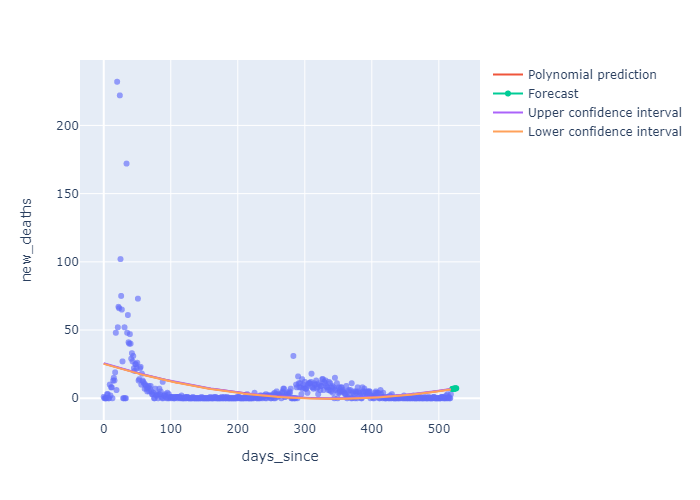

In [73]:
fig = px.scatter(nassau_deaths, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = nassau_deaths.days_since, y = n_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = nassau_deaths.days_since + 520, y = n_deaths_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = nassau_deaths.days_since, y = n_deaths_poly_2.predict(x) + 0.191699, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = nassau_deaths.days_since, y = n_deaths_poly_2.predict(x) - 0.191699, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows 7 new deaths predicted on day 520 which fractionally increases through the following week.

### Bronx county Analysis

In [74]:
bronx_cases =  cases.drop(cases.index[cases['countyFIPS']!= 36005])
bronx_cases = bronx_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in bronx_cases.iloc[:,:45].columns:
    extraneous_columns.append(col)
extraneous_columns
bronx_cases = bronx_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,528):
  new_cases[column] = bronx_cases.iloc[:,column] - bronx_cases.iloc[:,column-1]
bronx_cases = new_cases.sum().to_frame().reset_index()
bronx_cases = bronx_cases.rename(columns = {'index': 'days_since', 0: 'new_cases'})
bronx_cases['days_since'] = bronx_cases['days_since'].apply(lambda x: x-1)

bronx_deaths = deaths.drop(deaths.index[cases['countyFIPS']!= 36005])
bronx_deaths = bronx_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in bronx_deaths.iloc[:,:53].columns:
    extraneous_columns.append(col)
extraneous_columns
bronx_deaths = bronx_deaths.drop(columns=extraneous_columns)
new_deaths = pd.DataFrame()
for column in range(1,520):
  new_deaths[column] = bronx_deaths.iloc[:,column] - bronx_deaths.iloc[:,column-1]
bronx_deaths = new_deaths.sum().to_frame().reset_index()
bronx_deaths = bronx_deaths.rename(columns = {'index': 'days_since', 0: 'new_deaths'})
bronx_deaths['days_since'] = bronx_deaths['days_since'].apply(lambda x: x-1)

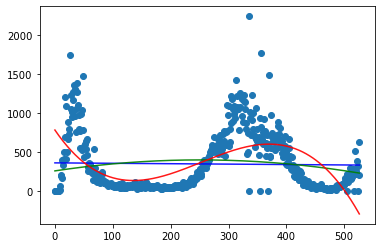

In [75]:
x = bronx_cases['days_since']
y = bronx_cases['new_cases']
b_lm = smf.ols(formula= 'new_cases ~ days_since', data = bronx_cases).fit()
b_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=bronx_cases).fit()
b_poly_3 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=bronx_cases).fit()
plt.scatter(bronx_cases.days_since, bronx_cases.new_cases)
x = pd.DataFrame({'days_since': np.linspace(bronx_cases.days_since.min(), bronx_cases.days_since.max(), 527)})
X_new = pd.DataFrame({'days_since':[528,529,530,531,532,533,534]})
plt.plot(bronx_cases.days_since, b_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % b_lm.rsquared, alpha=0.9)
plt.plot(bronx_cases.days_since, b_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % b_poly_2.rsquared, alpha=0.9)
plt.plot(bronx_cases.days_since, b_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % b_poly_3.rsquared, alpha=0.9)

In [76]:
b_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2438
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.622
Time:                        15:02:41   Log-Likelihood:                -3873.6
No. Observations:                 527   AIC:                             7751.
Df Residuals:                     525   BIC:                             7760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    363.5521     32.834     11.072      0.000     299.050     428.054
days_since    -0.0534      0.108     -0.494      0.622      -0.266       0.159
==============================================================================
Omnibus:                      119.529   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.356
Skew:                           1.347   Prob(JB):                     2.10e-46
Kurtosis:                       4.525   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
b_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.139
Date:                Thu, 28 Apr 2022   Prob (F-statistic):             0.0165
Time:                        15:02:41   Log-Likelihood:                -3869.6
No. Observations:                 527   AIC:                             7745.
Df Residuals:                     524   BIC:                             7758.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              260.6516     48.809      5.340      0.000     164.767     356.536
days_since               1.1226      0.429      2.619      0.009       0.281       1.965
I(days_since ** 2.0)    -0.0022      0.001     -2.834      0.005      -0.004      -0.001
==============================================================================
Omnibus:                      122.801   Durbin-Watson:                   0.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.155
Skew:                           1.359   Prob(JB):                     5.75e-49
Kurtosis:                       4.652   Cond. No.                     3.70e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
b_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     74.33
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           4.65e-40
Time:                        15:02:41   Log-Likelihood:                -3780.2
No. Observations:                 527   AIC:                             7568.
Df Residuals:                     523   BIC:                             7585.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              785.3142     54.790     14.333      0.000     677.680     892.949
days_since             -10.9040      0.903    -12.076      0.000     -12.678      -9.130
I(days_since ** 2.0)     0.0550      0.004     13.775      0.000       0.047       0.063
I(days_since ** 3.0) -7.252e-05   4.99e-06    -14.540      0.000   -8.23e-05   -6.27e-05
==============================================================================
Omnibus:                      105.909   Durbin-Watson:                   0.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.488
Skew:                           1.066   Prob(JB):                     3.28e-51
Kurtosis:                       5.459   Cond. No.                     2.19e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
b_poly_2.conf_int()

0           1
Intercept             164.766801  356.536424
days_since              0.280580    1.964708
I(days_since ** 2.0)   -0.003786   -0.000686

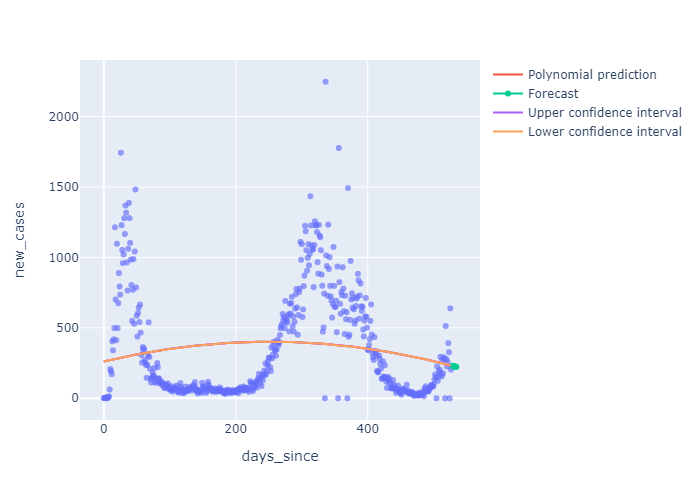

In [80]:
fig = px.scatter(bronx_cases, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = bronx_cases.days_since, y = b_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = bronx_cases.days_since + 528, y = b_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = bronx_cases.days_since, y = b_poly_2.predict(x) + 0.28058, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = bronx_cases.days_since, y = b_poly_2.predict(x) - 0.28058, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows a prediction of 230 new cases on day 528 which decreases to 223 on day 534.

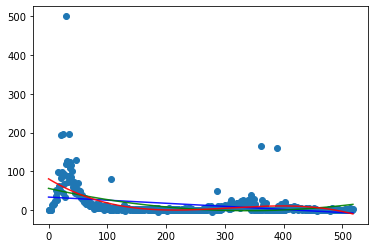

In [81]:
x = bronx_deaths['days_since']
y = bronx_deaths['new_deaths']
b_deaths_lm = smf.ols(formula= 'new_deaths ~ days_since', data = bronx_deaths).fit()
b_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=bronx_deaths).fit()
b_deaths_poly_3 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0) + I(days_since ** 3.0)', 
                    data=bronx_deaths).fit()
plt.scatter(bronx_deaths.days_since, bronx_deaths.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(bronx_deaths.days_since.min(), bronx_deaths.days_since.max(), 519)})
X_new = pd.DataFrame({'days_since':[520,521,522,523,524,525,526]})
plt.plot(bronx_deaths.days_since, b_deaths_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % b_deaths_lm.rsquared, alpha=0.9)
plt.plot(bronx_deaths.days_since, b_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         b_deaths_poly_2.rsquared, alpha=0.9)
plt.plot(bronx_deaths.days_since, b_deaths_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % 
         b_deaths_poly_3.rsquared, alpha=0.9)

In [82]:
b_deaths_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     71.26
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           3.17e-16
Time:                        15:02:42   Log-Likelihood:                -2537.1
No. Observations:                 519   AIC:                             5078.
Df Residuals:                     517   BIC:                             5087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.3290      2.821     11.814      0.000      27.787      38.871
days_since    -0.0796      0.009     -8.442      0.000      -0.098      -0.061
==============================================================================
Omnibus:                      749.201   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187307.420
Skew:                           7.573   Prob(JB):                         0.00
Kurtosis:                      94.827   Cond. No.                         598.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
b_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     67.79
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           7.22e-27
Time:                        15:02:42   Log-Likelihood:                -2510.0
No. Observations:                 519   AIC:                             5026.
Df Residuals:                     516   BIC:                             5039.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               55.7884      4.011     13.909      0.000      47.908      63.668
days_since              -0.3402      0.036     -9.512      0.000      -0.411      -0.270
I(days_since ** 2.0)     0.0005   6.69e-05      7.527      0.000       0.000       0.001
==============================================================================
Omnibus:                      760.803   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           215461.911
Skew:                           7.748   Prob(JB):                         0.00
Kurtosis:                     101.607   Cond. No.                     3.59e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
b_deaths_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     67.99
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           4.75e-37
Time:                        15:02:42   Log-Likelihood:                -2484.0
No. Observations:                 519   AIC:                             4976.
Df Residuals:                     515   BIC:                             4993.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               80.4244      5.074     15.849      0.000      70.456      90.393
days_since              -0.9137      0.085    -10.760      0.000      -1.081      -0.747
I(days_since ** 2.0)     0.0033      0.000      8.589      0.000       0.003       0.004
I(days_since ** 3.0) -3.566e-06   4.84e-07     -7.372      0.000   -4.52e-06   -2.62e-06
==============================================================================
Omnibus:                      774.728   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           264511.755
Skew:                           7.943   Prob(JB):                         0.00
Kurtosis:                     112.450   Cond. No.                     2.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
b_deaths_poly_2.conf_int()

0          1
Intercept             47.908381  63.668398
days_since            -0.410513  -0.269971
I(days_since ** 2.0)   0.000372   0.000635

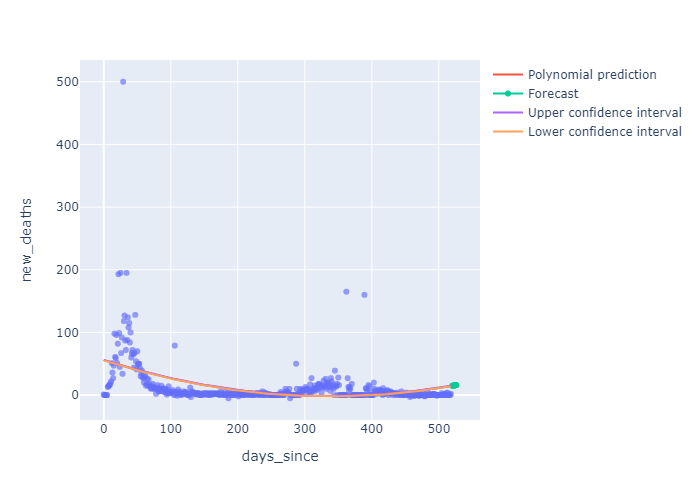

In [86]:
fig = px.scatter(bronx_deaths, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = bronx_deaths.days_since, y = b_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = bronx_deaths.days_since + 520, y = b_deaths_poly_2.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = bronx_deaths.days_since, y = b_deaths_poly_2.predict(x) + 0.410513, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = bronx_deaths.days_since, y = b_deaths_poly_2.predict(x) - 0.410513, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph predicts 15 new deaths on day 520 which increase to 16 new deaths on day 526.

## Hospital Data Analysis

Isolating relevant data and finding states with the fewest beds currently available.

In [87]:
beds_data = beds
extraneous_columns = []
for col in beds_data.iloc[:,1:9].columns:
    extraneous_columns.append(col)
extraneous_columns
beds_data = beds_data.drop(columns=extraneous_columns)
extraneous_columns = []
for col in beds_data.iloc[:,4:109].columns:
    extraneous_columns.append(col)
extraneous_columns
beds_data = beds_data.drop(columns=extraneous_columns)
beds_data = beds_data.drop(columns=['inpatient_beds_coverage'], axis=1)
beds_data['beds_left'] = beds_data.inpatient_beds - beds_data.inpatient_beds_used
beds_data.sort_values('beds_left').head(5)

state  inpatient_beds  inpatient_beds_used  beds_left
2     RI            1974                 1698        276
9     VT            1233                  887        346
13    AK            1584                 1168        416
29    ND            1904                 1332        572
21    DE            2585                 1956        629

We isolate Rhode Island's data from the cases dataframe and aggregate the cases on a weekly basis. The reasoning behind this is that hospitalization from covid lasts, on average, 6 days. This should give us relevant data as to how much space is being taken up in Rhode Island hospitals.

In [88]:
ri_cases =  cases[cases['State'].map(lambda State: 'RI' in State)]
ri_cases = ri_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
extraneous_columns = []
for col in ri_cases.iloc[:,:35].columns:
    extraneous_columns.append(col)
extraneous_columns
ri_cases = ri_cases.drop(columns=extraneous_columns)
new_cases = pd.DataFrame()
for column in range(1,538):
  new_cases[column] = ri_cases.iloc[:,column] - ri_cases.iloc[:,column-1]
week_cases = new_cases.groupby([[i//7 for i in range(1, 538)]], axis = 1).sum()

ri_cases = week_cases.sum().to_frame().reset_index()
ri_cases = ri_cases.rename(columns = {'index': 'weeks_since', 0: 'new_cases'})

ri_cases

weeks_since  new_cases
0             0          2
1             1          3
2             2         18
3             3         83
4             4        379
..          ...        ...
72           72        326
73           73        634
74           74       1183
75           75       1554
76           76       1050

[77 rows x 2 columns]

Graphing using prediction models and creating the dataframe of future weeks.

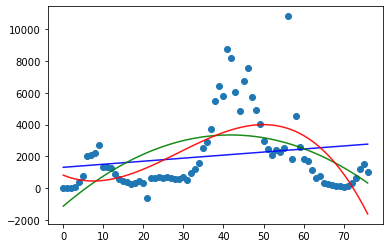

In [89]:
x = pd.DataFrame({'weeks_since': np.linspace(ri_cases.weeks_since.min(), ri_cases.weeks_since.max(), 77)})
X_new = pd.DataFrame({'weeks_since':[78,79,80,81,82,83,84]})
ri_lm = smf.ols(formula= 'new_cases ~ weeks_since', data = ri_cases).fit()
ri_poly_2 = smf.ols(formula='new_cases ~ weeks_since + I(weeks_since ** 2.0)', 
                    data=ri_cases).fit()
ri_poly_3 = smf.ols(formula='new_cases ~ weeks_since + I(weeks_since ** 2.0) + I(weeks_since ** 3.0)', 
                    data=ri_cases).fit()
plt.scatter(ri_cases.weeks_since, ri_cases.new_cases)
plt.plot(ri_cases.weeks_since, ri_lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % ri_lm.rsquared, alpha=0.9)
plt.plot(ri_cases.weeks_since, ri_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         ri_poly_2.rsquared, alpha=0.9)
plt.plot(ri_cases.weeks_since, ri_poly_3.predict(x), 'r-', label='Poly n=3 $R^2$=%.2f' % 
         ri_poly_3.rsquared, alpha=0.9)

In [90]:
ri_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.543
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.115
Time:                        15:02:46   Log-Likelihood:                -705.80
No. Observations:                  77   AIC:                             1416.
Df Residuals:                      75   BIC:                             1420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1317.6703    529.560      2.488      0.015     262.732    2372.609
weeks_since    19.1826     12.029      1.595      0.115      -4.781      43.146
==============================================================================
Omnibus:                       29.007   Durbin-Watson:                   0.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.365
Skew:                           1.566   Prob(JB):                     1.41e-10
Kurtosis:                       5.080   Cond. No.                         87.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
ri_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     13.37
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.11e-05
Time:                        15:02:46   Log-Likelihood:                -695.21
No. Observations:                  77   AIC:                             1396.
Df Residuals:                      74   BIC:                             1403.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1124.3593    685.833     -1.639      0.105   -2490.911     242.192
weeks_since             214.5450     41.715      5.143      0.000     131.425     297.665
I(weeks_since ** 2.0)    -2.5706      0.531     -4.841      0.000      -3.629      -1.512
==============================================================================
Omnibus:                       25.079   Durbin-Watson:                   0.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.361
Skew:                           1.328   Prob(JB):                     4.68e-09
Kurtosis:                       5.214   Cond. No.                     7.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
ri_poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     14.89
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.17e-07
Time:                        15:02:46   Log-Likelihood:                -688.71
No. Observations:                  77   AIC:                             1385.
Df Residuals:                      73   BIC:                             1395.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               822.7625    827.552      0.994      0.323    -826.547    2472.072
weeks_since            -103.3279     94.919     -1.089      0.280    -292.501      85.845
I(weeks_since ** 2.0)     7.9544      2.913      2.731      0.008       2.149      13.760
I(weeks_since ** 3.0)    -0.0923      0.025     -3.666      0.000      -0.143      -0.042
==============================================================================
Omnibus:                       24.016   Durbin-Watson:                   0.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.992
Skew:                           1.348   Prob(JB):                     4.16e-08
Kurtosis:                       4.825   Cond. No.                     6.46e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
ri_lm.conf_int()

0            1
Intercept    262.732142  2372.608518
weeks_since   -4.780860    43.146126

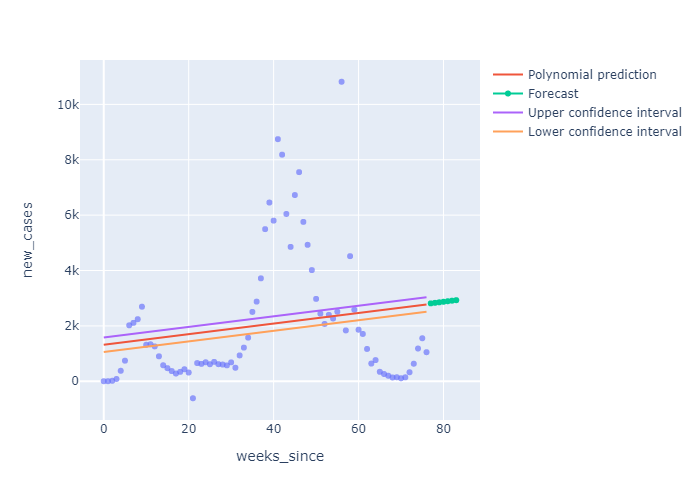

In [94]:
fig = px.scatter(ri_cases, x='weeks_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = ri_cases.weeks_since, y = ri_lm.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = ri_cases.weeks_since + 77, y = ri_lm.predict(X_new), name='Forecast'))
fig.add_trace(go.Scatter(x = ri_cases.weeks_since, y = ri_lm.predict(x) + 262.732142, 
                         name='Upper confidence interval'))
fig.add_trace(go.Scatter(x = ri_cases.weeks_since, y = ri_lm.predict(x) - 262.732142, 
                         name='Lower confidence interval'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The graph shows a prediction that the state hospital beds will be overcome by day 35.

## Hypothesis Testing

The hypothesis we will be testing is:
- Null hypothesis(H0) = political leaning of a state does not have any relation to covid cases.
- Alternate hypothesis(H1) = political leaning of a state does indicate a higher or lower covid case count.

First we get rid of unnecessary columns and just leave the state abbreviation, the two major party vote counts, the total number of covid cases, and the states population. Next we will normalize the vote count for each party by the state population.

In [95]:
extraneous_columns = []
for col in politics.iloc[:,:1].columns:
    extraneous_columns.append(col)
for col in politics.iloc[:,2:10].columns:
    extraneous_columns.append(col)
for col in politics.iloc[:,11:23].columns:
    extraneous_columns.append(col)
for col in politics.iloc[:,24:582].columns:
    extraneous_columns.append(col)
for col in politics.iloc[:,583:1120].columns:
    extraneous_columns.append(col)
politics_data = politics.drop(columns=extraneous_columns)
politics_data = politics_data.groupby('state_abbrev').sum()
politics_data = politics_data.reset_index()
politics_data = politics_data.rename(columns={'2021-08-16_cases': 'total_cases'})
politics_data['DEM'] = politics_data.DEM/politics_data.population*100000
politics_data['REP'] = politics_data.REP/politics_data.population*100000
politics_data['total_cases'] = politics_data.total_cases/politics_data.population*100000
politics_data

state_abbrev           DEM           REP   total_cases  population
0            AL  17328.491583  29392.486720  12998.958840     4903185
1            AR  14047.698260  25205.314858  13810.572191     3017804
2            AZ  22973.045937  22829.380508  13297.151133     7278717
3            CA  28117.284112  15200.260942  10207.147798    39512223
4            CO  31209.395614  23703.371376  10317.757364     5688271
5            DE  30425.031116  20600.782120  11762.500976      973764
6            FL  24662.956810  26393.520882  13396.257716    21477737
7            GA  23297.866158  23186.925867   9116.628395    10617423
8            HI  25860.546721  13904.926309   3512.324603     1415786
9            IA  24058.451952  28451.730073  12274.149226     3155070
10           ID  16061.027439  31007.210146  11718.096432     1787065
11           IL  27398.706153  19309.703002  11574.824171    12671821
12           IN  18455.950408  25695.123703  11987.637360     6732219
13           KS  19176.408722  26021.911816  12026.990568     2913314
14           KY  17290.298551  29694.339760  11616.293314     4467673
15           LA  18459.518566  26962.115297  13499.530202     4633902
16           MD  32606.402198  17443.265917   7812.108529     5452190
17           MI  28077.301998  26533.392838  10048.757081     9986857
18           MN  30456.741681  26300.987625  11096.236487     5633009
19           MO  18369.930039  30595.552141  11565.180924     5133841
20           MS  18124.025376  25427.624759  13070.111745     2976149
21           MT  22903.353175  32149.052469  11258.184581     1068778
22           NC  25593.730943  26303.879717  10701.687744    10488084
23           ND  15077.775824  30915.463571  14881.203892      762062
24           NE  19364.218924  28786.378055  11436.832354     1934408
25           NJ  29365.899626  21202.811469  11949.372846     8882190
26           NM  24148.237496  19646.828493  10090.203840     1878634
27           NV  22839.297750  21748.573774  12130.846619     3080156
28           NY  26956.535104  16707.635173  11269.587095    19453561
29           OH  22920.199160  26989.537261   9937.232122    11689100
30           OK  12734.235353  25784.368902  12640.577856     3956971
31           OR  31779.672369  22724.223914   5757.661040     4217737
32           PA  27026.448781  26388.579150   9779.456927    12801989
33           SC  21200.264765  26901.921528  12961.527869     5148714
34           SD  17008.926603  29507.753835  14294.095239      884659
35           TN  16750.385918  27132.827484  13461.071573     6829174
36           TX  18137.493391  20314.426728  11483.727637    28995881
37           UT  17476.273863  26985.381593  13673.635151     3205958
38           VA  27622.062372  25015.957597   8368.151513     6608138
39           WA  31118.126020  20809.891879   6740.475539     7614893
40           WI  28006.723649  27652.782324  12148.304300     5822434
41           WV  13167.669840  30431.767037   9679.953709     1792147
42           WY  12698.031478  33443.799578  11796.274442      578759

Graphing the data.

In [96]:
fig = px.bar(politics_data, x='state_abbrev', y='total_cases', opacity=0.65, title='US Covid cases vs Votes (Normalized)')
fig.add_trace(go.Scatter(x = politics_data.state_abbrev, y = politics_data.REP, name='REP'))
fig.add_trace(go.Scatter(x = politics_data.state_abbrev, y = politics_data.DEM, name='DEM'))

fig.show()
#fig_img = fig.to_image(format='png')
#Image(fig_img)

Applying a mask to the state abbreviations to sepereate them out into democrat or republican states depending on which way they voted, changing state_abbrev column name to party, and getting rid of all columns except for party and total_cases.

In [97]:
pol_mask = {'AL':'REP','AR':'REP','AZ':'DEM','CA':'DEM','CO':'DEM','DE':'DEM','FL':'REP','GA':'DEM','HI':'DEM','IA':'REP',
            'ID':'REP','IL':'DEM','IN':'REP','KS':'REP','KY':'REP','LA':'REP','MD':'DEM','MI':'DEM','MN':'DEM','MO':'REP',
            'MS':'REP','MT':'REP','NC':'REP','ND':'REP','NE':'REP','NJ':'DEM','NM':'DEM','NV':'DEM','NY':'DEM','OH':'REP',
            'OK':'REP','OR':'DEM','PA':'DEM','SC':'REP','SD':'REP','TN':'REP','TX':'REP','UT':'REP','VA':'DEM','WA':'DEM','WI':'DEM',
            'WV':'REP','WY':'REP'}

pol_compare = politics_data
pol_compare['state_abbrev'] = pol_compare['state_abbrev'].map(pol_mask)
pol_compare = pol_compare.drop(columns={'DEM','REP','population'})
pol_compare = pol_compare.rename(columns={'state_abbrev':'party'})
pol_compare 

party   total_cases
0    REP  12998.958840
1    REP  13810.572191
2    DEM  13297.151133
3    DEM  10207.147798
4    DEM  10317.757364
5    DEM  11762.500976
6    REP  13396.257716
7    DEM   9116.628395
8    DEM   3512.324603
9    REP  12274.149226
10   REP  11718.096432
11   DEM  11574.824171
12   REP  11987.637360
13   REP  12026.990568
14   REP  11616.293314
15   REP  13499.530202
16   DEM   7812.108529
17   DEM  10048.757081
18   DEM  11096.236487
19   REP  11565.180924
20   REP  13070.111745
21   REP  11258.184581
22   REP  10701.687744
23   REP  14881.203892
24   REP  11436.832354
25   DEM  11949.372846
26   DEM  10090.203840
27   DEM  12130.846619
28   DEM  11269.587095
29   REP   9937.232122
30   REP  12640.577856
31   DEM   5757.661040
32   DEM   9779.456927
33   REP  12961.527869
34   REP  14294.095239
35   REP  13461.071573
36   REP  11483.727637
37   REP  13673.635151
38   DEM   8368.151513
39   DEM   6740.475539
40   DEM  12148.304300
41   REP   9679.953709
42   REP  11796.274442

We use the groupby and describe functions on the party column to get a comparison of the states broken down by party preference.

In [98]:
pol_compare_trial = pol_compare.groupby('party')
pol_compare_trial.describe()

total_cases                                                        \
            count          mean          std          min           25%   
party                                                                     
DEM          19.0   9841.026119  2482.068056  3512.324603   8742.389954   
REP          24.0  12340.407612  1313.205610  9679.953709  11544.817602   

                                                 
                50%           75%           max  
party                                            
DEM    10207.147798  11668.662573  13297.151133  
REP    12150.569897  13412.461180  14881.203892

In [99]:
pol_compare_bar = pol_compare_trial.mean().reset_index()
pol_compare_bar

party   total_cases
0   DEM   9841.026119
1   REP  12340.407612

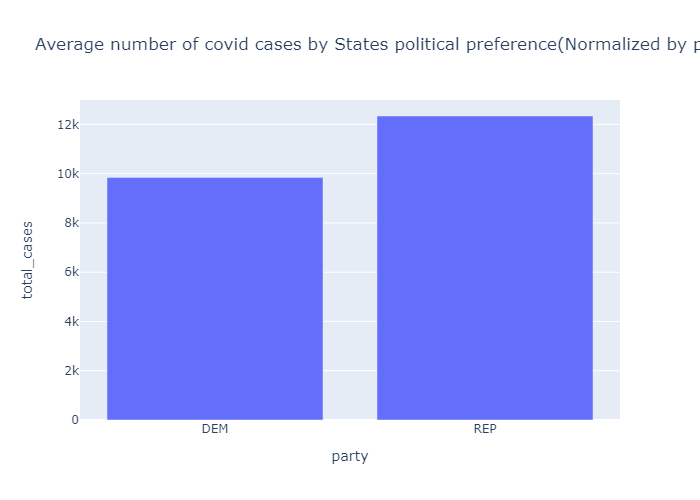

In [100]:

fig = px.bar(pol_compare_bar, x='party', y='total_cases', barmode='group', 
             title='Average number of covid cases by States political preference(Normalized by population)')
#fig.show()
fig_img = fig.to_image(format='png')
Image(fig_img)

This graph shows the mean number of covid cases for democratic leaning states versus republican leaning states. The graph shows that republican leaning states have a higher mean covid case count, normalized by population. 

We are going to split the dataframe into two seperate ones holding only democratic state total_cases and republican state total_cases respectively.

In [101]:
pol_compare_dem = pol_compare
pol_compare_rep = pol_compare
pol_compare_dem = pol_compare_dem.drop([0,1,6,9,10,12,13,14,15,19,20,21,22,23,24,29,30,33,34,35,36,37,41,42])
pol_compare_rep = pol_compare_rep.drop([2,3,4,5,7,8,11,16,17,18,25,26,27,28,31,32,38,39,40])
pol_compare_dem = pol_compare_dem.drop(columns={'party'})
pol_compare_rep = pol_compare_rep.drop(columns={'party'})
pol_compare_dem

total_cases
2   13297.151133
3   10207.147798
4   10317.757364
5   11762.500976
7    9116.628395
8    3512.324603
11  11574.824171
16   7812.108529
17  10048.757081
18  11096.236487
25  11949.372846
26  10090.203840
27  12130.846619
28  11269.587095
31   5757.661040
32   9779.456927
38   8368.151513
39   6740.475539
40  12148.304300

Generating the samples for the T tests.

In [102]:
dem_samp = pol_compare_dem.sample(n=15)
rep_samp = pol_compare_rep.sample(n=15)
print(dem_samp)
print(rep_samp)

     total_cases
5   11762.500976
28  11269.587095
11  11574.824171
18  11096.236487
40  12148.304300
8    3512.324603
31   5757.661040
7    9116.628395
25  11949.372846
2   13297.151133
4   10317.757364
38   8368.151513
39   6740.475539
32   9779.456927
3   10207.147798
     total_cases
41   9679.953709
1   13810.572191
20  13070.111745
42  11796.274442
21  11258.184581
14  11616.293314
34  14294.095239
23  14881.203892
15  13499.530202
0   12998.958840
24  11436.832354
13  12026.990568
33  12961.527869
22  10701.687744
30  12640.577856


Running 1 sample T tests for both democrat and republican data sets.

In [103]:
print('Democrat 1 sample T test')
print(stats.ttest_1samp(a=dem_samp, popmean=9841.026119))
print('Republican 1 sample T test')
print(stats.ttest_1samp(a=rep_samp, popmean=12340.407612))

Democrat 1 sample T test
Ttest_1sampResult(statistic=array([-0.06886933]), pvalue=array([0.94606762]))
Republican 1 sample T test
Ttest_1sampResult(statistic=array([0.28744718]), pvalue=array([0.77798087]))


Running two sample T test.

In [104]:
stats.ttest_ind(a= dem_samp,
                b= rep_samp,
                equal_var=False)

Ttest_indResult(statistic=array([-3.38171681]), pvalue=array([0.00279931]))

Due to the pvalue being less than .05 we would reject the null hypothesis.